### ChEMBL Compound Data Acquisition for SARS-CoV-2 Mpro

#### Extracting Bioactivity Data for a Target

##### **Project Overview**

This project retrieves and processes bioactivity and compound data from the ChEMBL database for the target protein **SARS-CoV-2 Main Protease (Mpro)**. Mpro is a crucial enzyme for viral replication, making it a key target for developing antiviral therapeutics against COVID-19. We will extract both IC50 and Ki bioactivity data. Ki (inhibition constant) provides a more fundamental measure of binding affinity compared to IC50, offering deeper insights into compound potency. The final dataset includes molecular properties, bioactivity values (IC50 and Ki), and their corresponding pIC50 and pKi scores, providing a comprehensive foundation for cheminformatics analysis and drug discovery research related to COVID-19.

##### **Key Steps**

1.  Connect to ChEMBL
2.  Retrieve Target Data (SARS-CoV-2 Mpro)
3.  Fetch Bioactivity Data (IC50 and Ki)
4.  Preprocess IC50 and Ki Data (calculate the pIC50 and pKi)
5.  Retrieve Compound Data. Preprocess and Filter Compound Data
6.  Merge Bioactivity and Compound Data
7.  Visualize Potent Compounds (based on pIC50 and pKi)
8.  Freeze Data to ChEMBL 27

##### **Requirements**

-   Python 3.x
-   Libraries: `pandas`, `numpy`, `rdkit`, `chembl_webresource_client`, `tqdm`


In [119]:
import os

##### **Importing Required Libraries**

- **Math & File Handling**: `math`, `Path`, `ZipFile`, `TemporaryDirectory`
- **Data Processing**: `numpy`, `pandas`
- **Cheminformatics**: `rdkit (PandasTools)`
- **ChEMBL API**: `chembl_webresource_client`
- **Progress Tracking**: `tqdm`

These libraries help with **data retrieval, processing, and visualization**.

In [120]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

##### 1. **Connect to ChEMBL:** That is establish a connection with the **API**

In [121]:
# Define the project root directory
HERE = Path("F:\CHEMOINFORMATICS")

# Define the data directory
DATA = HERE / "data"

In [122]:
targets_api = new_client.target # Access target (protein) data 
compounds_api = new_client.molecule # Access compound (inhibitors) data 
bioactivities_api = new_client.activity # Access bioactivity (IC50 and Ki) data 

In [123]:
type(targets_api) # Check the object type

chembl_webresource_client.query_set.QuerySet

##### 2. Retrieve Mpro

-   Use the ChEMBL API to search for the target protein, extract ChEMBL Target ID.
-   Retrieve the ChEMBL Target ID for Mpro from the search results.
-   Get UniProt ID.
-   [https://www.uniprot.org/](https://www.uniprot.org/) and search for **Mpro**.
-   Retrieve the UniProt ID: **P0DTD1**.

In [124]:
uniprot_id = "P0DTD1"

In [125]:
# Retrieve Mpro information from ChEMBL using its UniProt ID.
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'Type of the targets is "{type(targets)}"')

Type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [126]:
# Convert the ChEMBL data to dataframe
targets = pd.DataFrame.from_records(targets)

In [127]:
targets

,organism,pref_name,target_chembl_id,target_type
0,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,CHEMBL4523582,SINGLE PROTEIN
1,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,CHEMBL4523582,SINGLE PROTEIN


In [128]:
# Select any of the target ChEMBL ID, since they are both the same
target = targets.iloc[0]
target

organism            Severe acute respiratory syndrome coronavirus 2
pref_name                                 Replicase polyprotein 1ab
target_chembl_id                                      CHEMBL4523582
target_type                                          SINGLE PROTEIN
Name: 0, dtype: object

In [129]:
#Save selected ChEMBL ID to a variable
chembl_id = target.target_chembl_id
print(f"ChEMBL ID is {chembl_id}")

ChEMBL ID is CHEMBL4523582


##### **3. Fetch Bioactivity Data (IC50 and Ki)**

-   **Retrieve Bioactivity Data:**
    -   Use the ChEMBL API to retrieve bioactivity data for the target (SARS-CoV-2 Mpro).
    -   Filter for:
        -   Bioactivity types: **IC50 and Ki**.
        -   Exact measurements (relation '=').
        -   Binding assays (assay type 'B').
    -   Retrieve relevant fields: `activity_id`, `assay_chembl_id`, `assay_description`, `assay_type`, `molecule_chembl_id`, `type`, `standard_units`, `relation`, `standard_value`, `target_chembl_id`, and `target_organism`.

In [130]:
# Correctly filter for both IC50 and Ki bioactivity types
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id,  # Target ChEMBL ID
    type__in=["IC50", "Ki"],     # Filter for both IC50 and Ki
    relation="=",                # Exact measurements
    assay_type="B"               # Binding assays
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",                      # Bioactivity type (IC50 or Ki)
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

In [131]:
# Print the length and type of the bioactivities object
print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 1931, <class 'chembl_webresource_client.query_set.QuerySet'>


In [132]:
#Inspects the first record (bioactivities[0]) to understand its structure

print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 23150136,
 'assay_chembl_id': 'CHEMBL4810314',
 'assay_description': 'Inhibition of SARS-CoV-2 3CLpro preincubated for 30 mins followed by addition of (Dabcyl)KTSAVLQSGFRKM(Glu) peptide substrate and measured after 1.5 hrs by FRET assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL2316746',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '94.0',
 'target_chembl_id': 'CHEMBL4523582',
 'target_organism': 'Severe acute respiratory syndrome coronavirus 2',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.094'}

In [133]:
#Converts the bioactivities object into a Pandas DataFrame.
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (1931, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,23150136,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL2316746,=,nM,94.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,uM,0.094
1,23150137,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL213543,=,nM,286.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,uM,0.28600000000000003
2,23150138,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL4796938,=,nM,14.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,uM,0.013999999999999999
3,23150139,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL4764751,=,nM,23.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,uM,0.023
4,23150140,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL4857345,=,nM,65.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,uM,0.065


In [134]:
# To check if both 'IC50' and 'Ki' are present in the data
bioactivities_df['type'].unique()

array(['IC50', 'Ki'], dtype=object)

In [135]:
#To check for the value counts for both 'IC50', 'Ki' present in the data
bioactivities_df["type"].value_counts()

type
IC50    1827
Ki       104
Name: count, dtype: int64

In [136]:
# Check the unique values in the units column of your DataFrame
bioactivities_df["units"].unique()

array(['uM', 'nM', 'mM', 'ug ml-1'], dtype=object)

In [137]:
# Check the unique values in the units column of your DataFrame
bioactivities_df["standard_units"].unique()

array(['nM', 'ug.mL-1'], dtype=object)

In [138]:
#Drop non-standard columns ('units' and 'values') and use only the standardized data
bioactivities_df.drop(["units", "value"], axis = 1, inplace = True)

In [139]:
bioactivities_df.head(2)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,23150136,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL2316746,=,nM,94.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50
1,23150137,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL213543,=,nM,286.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50


In [140]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

##### **4. Preprocess Bioactivity Data**

-   **Convert to Numeric:** Convert `standard_value` to numeric.
-   **Handle Missing Data:** Remove rows with missing `standard_value` or `standard_units`.
-   **Filter Units:** Keep only entries with `standard_units` as 'nM'.
-   **Resolve variability in Standard value:** Use the mean aggregate.
-   **Reset Index:** Reset the DataFrame index.
-   **Separate Data:** Create separate DataFrames for IC50 and Ki.
-   **Calculate p Values:**
    -   Calculate pIC50 for the IC50 DataFrame.
    -   Calculate pKi for the Ki DataFrame.
-   **Combine:** Combine processed IC50 and Ki DataFrames.

In [141]:
# Convert to Numeric:** Convert `standard_value` to numeric.
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [142]:
# Remove rows with missing values
bioactivities_df.dropna(axis = 0, how = "any", inplace = True)

In [143]:
bioactivities_df.shape

(1931, 11)

In [144]:
#Number of entries with standard_units 'nM'
len(bioactivities_df[bioactivities_df["standard_units"] == "nM"])

1918

In [145]:
#Number of entries without standard_units 'nM'
len(bioactivities_df[bioactivities_df["standard_units"] != "nM"])

13

In [146]:
 #Filter Units:** Keep only entries with `standard_units` as 'nM'.
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]

In [147]:
#Cross-check if its only contains "nM"
bioactivities_df["standard_units"].unique()

array(['nM'], dtype=object)

In [148]:
bioactivities_df.shape

(1918, 11)

In [149]:
bioactivities_df["molecule_chembl_id"].value_counts()

molecule_chembl_id
CHEMBL4802135    32
CHEMBL3427166    19
CHEMBL51085      18
CHEMBL4796938    16
CHEMBL8260       15
                 ..
CHEMBL5206974     1
CHEMBL5200159     1
CHEMBL5200032     1
CHEMBL5189954     1
CHEMBL5418521     1
Name: count, Length: 1455, dtype: int64

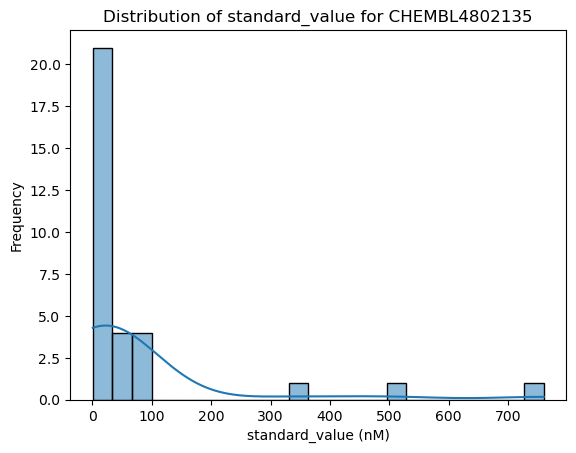

In [150]:
#Analyze the variability in measurements for each molecule
# Plot the distribution of standard_value for a specific molecule
sns.histplot(bioactivities_df[bioactivities_df["molecule_chembl_id"] == "CHEMBL4802135"]["standard_value"], kde=True)
plt.title("Distribution of standard_value for CHEMBL4802135")
plt.xlabel("standard_value (nM)")
plt.ylabel("Frequency")
plt.show()

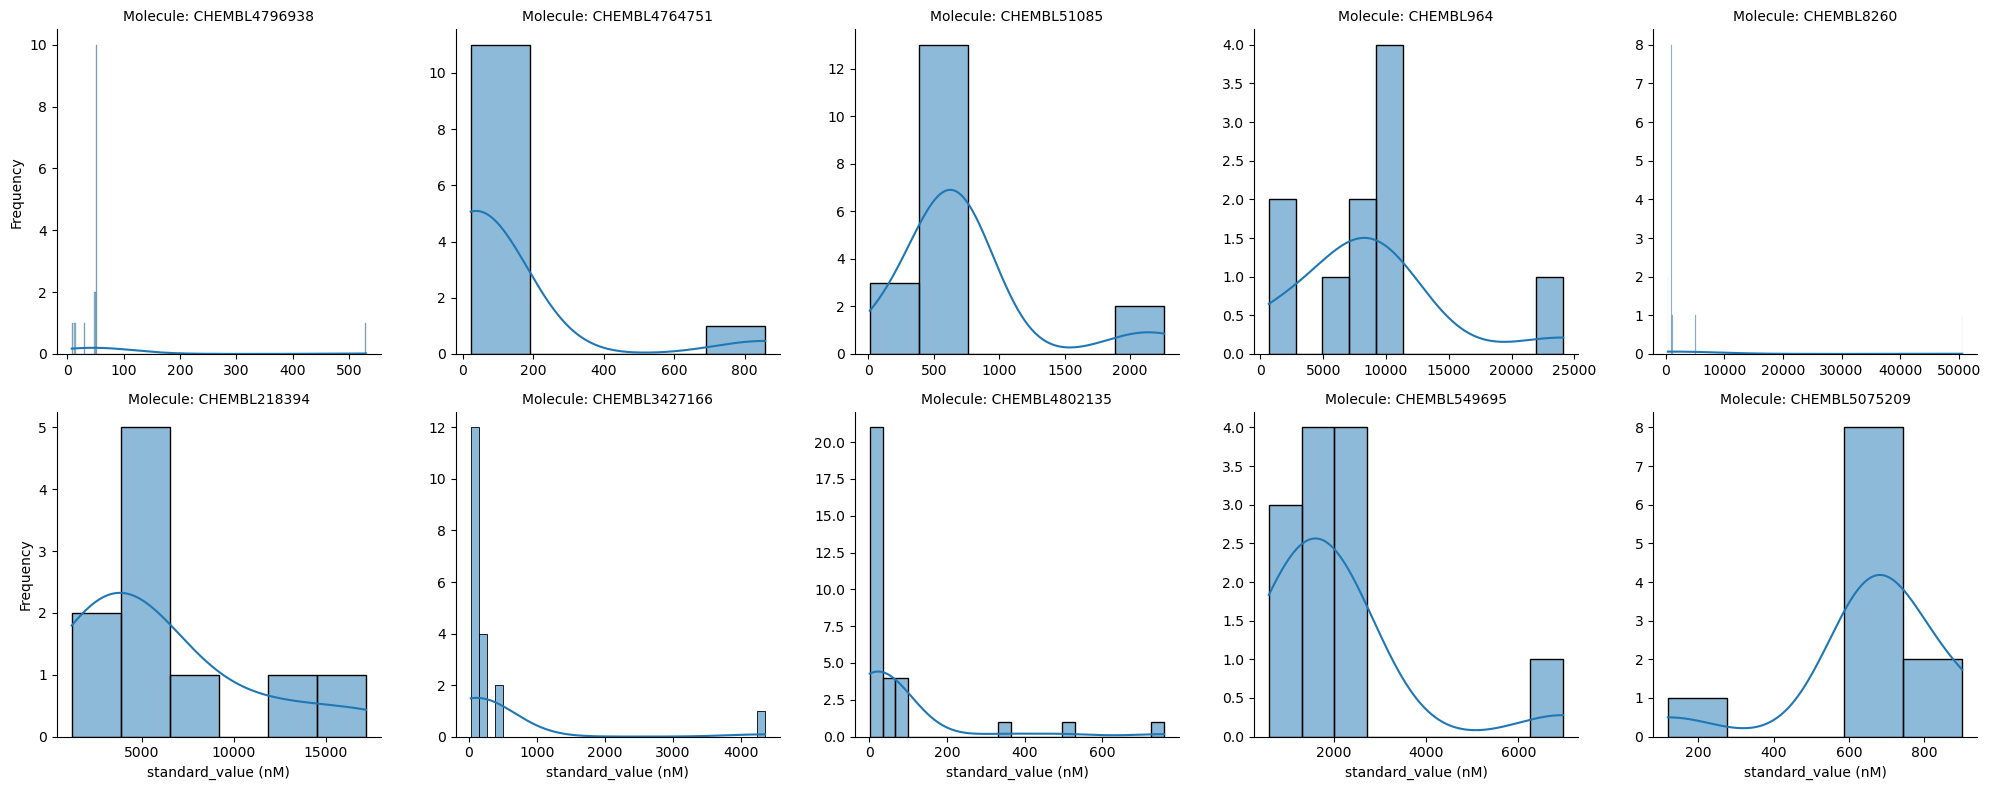

In [151]:
# Create a faceted plot for the top 10 molecules
top_molecules = bioactivities_df["molecule_chembl_id"].value_counts().head(10).index.tolist()
filtered_df = bioactivities_df[bioactivities_df["molecule_chembl_id"].isin(top_molecules)]

# Use FacetGrid to create separate histograms
g = sns.FacetGrid(filtered_df, col="molecule_chembl_id", col_wrap=5, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "standard_value", kde=True)
g.set_axis_labels("standard_value (nM)", "Frequency")
g.set_titles("Molecule: {col_name}")
plt.show()

In [152]:
bioactivities_df.head(2)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,23150136,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL2316746,=,nM,94.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50
1,23150137,CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,CHEMBL213543,=,nM,286.0,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50


In [153]:
#Resolve variability in Standard value: Use the mean aggregate.
mean_df = bioactivities_df.groupby('molecule_chembl_id', as_index=False).agg({
    'standard_value': 'mean',  # Calculate mean standard_value
    'activity_id': 'first',    # Retain the first activity_id
    'assay_chembl_id': 'first',  # Retain the first assay_chembl_id
    'assay_description': 'first',  # Retain the first assay_description
    'assay_type': 'first',  # Retain the first assay_type
    'relation': 'first',  # Retain the first relation
    'standard_units': 'first',  # Retain the first standard_units
    'target_chembl_id': 'first',  # Retain the first target_chembl_id
    'target_organism': 'first',  # Retain the first target_organism
    'type': 'first'  # Retain the first type
})


In [154]:
# Create a new column for the mean standard_value
mean_df['mean_standard_value'] = mean_df['standard_value']

In [155]:
# Display the aggregated DataFrame
print(f"Aggregated DataFrame shape: {mean_df.shape}")
mean_df.head()

Aggregated DataFrame shape: (1455, 12)


,molecule_chembl_id,standard_value,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,target_chembl_id,target_organism,type,mean_standard_value
0,CHEMBL103299,77.0,25554594,CHEMBL5346746,Inhibition of SARS-Cov-2 main protease using f...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,77.0
1,CHEMBL1082333,6100.0,25087282,CHEMBL5257312,Inhibition of SARS-CoV-2 3CL protease,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,6100.0
2,CHEMBL1096283,260.0,25051214,CHEMBL5247358,Inhibition of N-terminal MBP-tagged SARS CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,260.0
3,CHEMBL1116,5610.0,25516580,CHEMBL5336352,Inhibition of N-terminal His-tagged SARS-CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,5610.0
4,CHEMBL117102,14400.0,25609263,CHEMBL5360285,Inhibition of recombinant SARS-CoV-2 3CLPro DA...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,14400.0


In [156]:
# Reset the DataFrame index 
mean_df.reset_index(drop=True, inplace=True)
mean_df.head()

,molecule_chembl_id,standard_value,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,target_chembl_id,target_organism,type,mean_standard_value
0,CHEMBL103299,77.0,25554594,CHEMBL5346746,Inhibition of SARS-Cov-2 main protease using f...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,77.0
1,CHEMBL1082333,6100.0,25087282,CHEMBL5257312,Inhibition of SARS-CoV-2 3CL protease,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,6100.0
2,CHEMBL1096283,260.0,25051214,CHEMBL5247358,Inhibition of N-terminal MBP-tagged SARS CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,260.0
3,CHEMBL1116,5610.0,25516580,CHEMBL5336352,Inhibition of N-terminal His-tagged SARS-CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,5610.0
4,CHEMBL117102,14400.0,25609263,CHEMBL5360285,Inhibition of recombinant SARS-CoV-2 3CLPro DA...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,14400.0


In [157]:
#Separate DataFrames for IC50 and Ki
ic50_df = mean_df[mean_df["type"] == "IC50"].copy()
Ki_df = mean_df[mean_df["type"] == "Ki"].copy()

In [158]:
#Reset the Index for both
ic50_df.reset_index(drop=True, inplace = True)
Ki_df.reset_index(drop=True, inplace = True)

In [159]:
ic50_df.shape

(1419, 12)

In [160]:
Ki_df.shape

(36, 12)

In [161]:
#Calculate pIC50 and pKi
ic50_df['pIC50'] = -np.log10(ic50_df['mean_standard_value'] * 1e-9) 
Ki_df['pKi'] = -np.log10(Ki_df['mean_standard_value'] * 1e-9) 

In [162]:
#Combine the p-values
combined_bioactivities_df = pd.concat([ic50_df, Ki_df], ignore_index=True)

In [163]:
combined_bioactivities_df.head()

,molecule_chembl_id,standard_value,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,target_chembl_id,target_organism,type,mean_standard_value,pIC50,pKi
0,CHEMBL103299,77.0,25554594,CHEMBL5346746,Inhibition of SARS-Cov-2 main protease using f...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,77.0,7.113509,NaN
1,CHEMBL1082333,6100.0,25087282,CHEMBL5257312,Inhibition of SARS-CoV-2 3CL protease,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,6100.0,5.214670,NaN
2,CHEMBL1096283,260.0,25051214,CHEMBL5247358,Inhibition of N-terminal MBP-tagged SARS CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,260.0,6.585027,NaN
3,CHEMBL1116,5610.0,25516580,CHEMBL5336352,Inhibition of N-terminal His-tagged SARS-CoV-2...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,5610.0,5.251037,NaN
4,CHEMBL117102,14400.0,25609263,CHEMBL5360285,Inhibition of recombinant SARS-CoV-2 3CLPro DA...,B,=,nM,CHEMBL4523582,Severe acute respiratory syndrome coronavirus 2,IC50,14400.0,4.841638,NaN


##### **5. Retrieve Compound Data**

-   **Fetch Compound Structures:** Use `molecule_chembl_id` to retrieve molecular structures (canonical SMILES) from ChEMBL.

In [164]:
# Fetch Compound data
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(combined_bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [165]:
#Convert the Query to a list with a progress bar for tracking.
compounds = list(tqdm(compounds_provider))

  0%|          | 0/1455 [00:00<?, ?it/s]

In [166]:
# Convert the compounds data to a DataFrame
compounds_df = pd.DataFrame.from_records(compounds)

In [167]:
compounds_df.shape

(1455, 2)

In [168]:
compounds_df.head(2)

,molecule_chembl_id,molecule_structures
0,CHEMBL456,{'canonical_smiles': 'C=C(CC)C(=O)c1ccc(OCC(=O...
1,CHEMBL8260,{'canonical_smiles': 'O=c1cc(-c2ccccc2)oc2cc(O...


In [169]:
#Remove entries with missing molecule structure entry
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.shape

(1453, 2)

In [170]:
#Check the value counts
compounds_df["molecule_chembl_id"].value_counts()

molecule_chembl_id
CHEMBL456        1
CHEMBL5281998    1
CHEMBL5281483    1
CHEMBL5281399    1
CHEMBL5281103    1
                ..
CHEMBL5182841    1
CHEMBL5182830    1
CHEMBL5182801    1
CHEMBL5182755    1
CHEMBL5441037    1
Name: count, Length: 1453, dtype: int64

In [171]:
# Inspect the structure of molecule_structures
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [172]:
# Extract canonical SMILES from molecule structures
canonical_smiles = []  # Initialize list to store SMILES

# Iterate through rows and extract canonical SMILES
for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)  # Handle missing SMILES

compounds_df["smiles"] = canonical_smiles  # Add SMILES column
compounds_df.drop("molecule_structures", axis=1, inplace=True)  # Remove original structure column


In [173]:
compounds_df.shape #print new dataframe shape.

(1453, 2)

In [174]:
#Remove all molecules without a canonical SMILES string if prese
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1453, 2)


In [175]:
# Summary of bioactivity data output
print(f"Bioactivities filtered: {combined_bioactivities_df.shape[0]}")
combined_bioactivities_df.columns

Bioactivities filtered: 1455


Index(['molecule_chembl_id', 'standard_value', 'activity_id',
       'assay_chembl_id', 'assay_description', 'assay_type', 'relation',
       'standard_units', 'target_chembl_id', 'target_organism', 'type',
       'mean_standard_value', 'pIC50', 'pKi'],
      dtype='object')

In [176]:
# Summary of compound data output
print(f"compound filtered: {compounds_df.shape[0]}")
compounds_df.columns

compound filtered: 1453


Index(['molecule_chembl_id', 'smiles'], dtype='object')

##### **6. Merge Bioactivity & Compound Data**

-   **Combine DataFrames:** Merge `combined_bioactivities_df` and `compounds_df` based on `molecule_chembl_id` using a left merge.
-   **Select Key Columns:** Retain `molecule_chembl_id`, `smiles`, `standard_units`, `pIC50`, and `pKi`.

In [177]:
# Merge bioactivity and compound data on 'molecule_chembl_id'.
output_df = pd.merge(combined_bioactivities_df, compounds_df, on="molecule_chembl_id", how='left')

In [178]:
#Select the unique Columns:
output_df = output_df[['molecule_chembl_id', 'smiles', 'standard_units', 'pIC50', 'pKi']]

In [179]:
# Reset row indices after merging and print the resulting dataset size.
output_df.reset_index(drop=True, inplace=True)
print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 1455 entries.


In [180]:
output_df.head()

,molecule_chembl_id,smiles,standard_units,pIC50,pKi
0,CHEMBL103299,Cc1ccc(CCN)cc1,nM,7.113509,NaN
1,CHEMBL1082333,N#Cc1c(-c2ccc(Cl)cc2)nc(SCc2ccc([N+](=O)[O-])c...,nM,5.214670,NaN
2,CHEMBL1096283,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,nM,6.585027,NaN
3,CHEMBL1116,Cl.O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)...,nM,5.251037,NaN
4,CHEMBL117102,CCC(CC)CC1(C(=O)Nc2ccccc2S)CCCCC1,nM,4.841638,NaN


##### **7. Visualize Top Compounds**

-   **Draw Molecular Structures:** Visualize structures of most potent compounds (highest pIC50/pKi).
-   **RDKit Grid:** Use RDKit to convert SMILES to molecular structures and display in a grid.

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

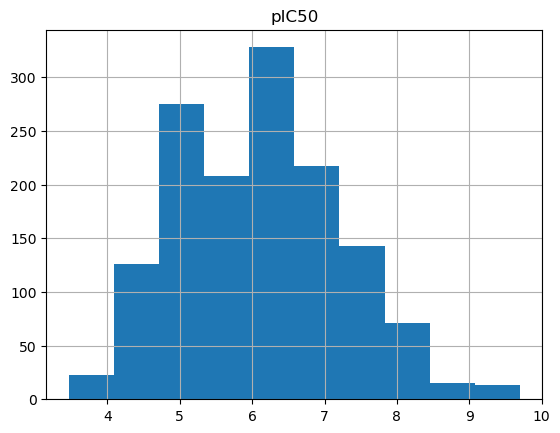

In [181]:
# Plot the distribution of pIC50 values using a histogram.
output_df.hist(column="pIC50")

array([[<Axes: title={'center': 'pKi'}>]], dtype=object)

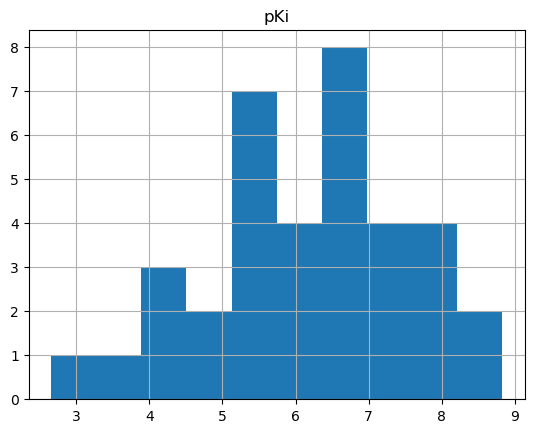

In [182]:
# Plot the distribution of pKi values using a histogram.
output_df.hist(column="pKi")

In [183]:
# Display the first 3 rows of the DataFrame after dropping the 'smiles' column.
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,standard_units,pIC50,pKi
0,CHEMBL103299,nM,7.113509,NaN
1,CHEMBL1082333,nM,5.214670,NaN
2,CHEMBL1096283,nM,6.585027,NaN


In [188]:
# Data for only pIC50
pIC50_output_df = output_df.drop("pKi", axis=1).head(3)
pIC50_output_df

,molecule_chembl_id,smiles,standard_units,pIC50
0,CHEMBL103299,Cc1ccc(CCN)cc1,nM,7.113509
1,CHEMBL1082333,N#Cc1c(-c2ccc(Cl)cc2)nc(SCc2ccc([N+](=O)[O-])c...,nM,5.214670
2,CHEMBL1096283,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,nM,6.585027


In [190]:
# Data for only pKi
pKi_output_df = output_df.drop("pIC50", axis=1).head(3)
pKi_output_df

,molecule_chembl_id,smiles,standard_units,pKi
0,CHEMBL103299,Cc1ccc(CCN)cc1,nM,NaN
1,CHEMBL1082333,N#Cc1c(-c2ccc(Cl)cc2)nc(SCc2ccc([N+](=O)[O-])c...,nM,NaN
2,CHEMBL1096283,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,nM,NaN


In [191]:
output_df.head()

,molecule_chembl_id,smiles,standard_units,pIC50,pKi
0,CHEMBL103299,Cc1ccc(CCN)cc1,nM,7.113509,NaN
1,CHEMBL1082333,N#Cc1c(-c2ccc(Cl)cc2)nc(SCc2ccc([N+](=O)[O-])c...,nM,5.214670,NaN
2,CHEMBL1096283,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,nM,6.585027,NaN
3,CHEMBL1116,Cl.O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)...,nM,5.251037,NaN
4,CHEMBL117102,CCC(CC)CC1(C(=O)Nc2ccccc2S)CCCCC1,nM,4.841638,NaN


##### **8. Freeze Data to ChEMBL 27**

-   **Ensure Reproducibility:** Preserve dataset consistency by freezing data to ChEMBL version 27.
-   **Document Version:** Dataset is based on ChEMBL 27.
-   **Save Dataset:** Save the final DataFrame to a CSV

In [193]:
# Define the data directory
DATA = Path("F:/CHEMOINFORMATICS/data")

In [194]:
# Save the DataFrame to CSV
output_df.to_csv(DATA / "MPro_compounds_200325.csv", index=False)

print("File saved successfully!")

File saved successfully!
